In [1]:
import os
import re
import math
import typing
import warnings
from enum import Enum

import numpy as np
import pandas as pd
import seaborn as sns
import pingouin as pg
import matplotlib as mpl
from scipy.stats import zscore
import matplotlib.pyplot as plt

import sklearn
from sklearn.cluster import KMeans
from sklearn.metrics import accuracy_score
from sklearn.linear_model import Ridge, Lasso, LinearRegression, HuberRegressor
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor
from sklearn.neighbors import KNeighborsClassifier, KNeighborsRegressor
from sklearn.metrics import silhouette_score, mean_squared_error, r2_score
from sklearn.model_selection import GridSearchCV, RepeatedKFold, cross_val_score, train_test_split

from IPython.display import display, HTML
display(HTML("<style>.container { width: 90% !important}; </style>"))

In [2]:
warnings.filterwarnings(
    action='ignore',
    message='înternal gelsd'
)

warnings.filterwarnings(
    action='ignore',
    category=UserWarning
)

warnings.filterwarnings(
    action='ignore',
    category=RuntimeWarning
)

np.random.seed(1)

pd.set_option('display.max_rows', 20)
pd.set_option('display.max_columns', 500)
pd.set_option('display.max_colwidth', 50)

pd.options.mode.chained_assignment = None  # default='warn'

In [3]:
# Matplotlib set label size
%matplotlib inline

mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=14)
mpl.rc('ytick', labelsize=14)

plt.rc('font', size=12)
plt.rc('figure', figsize=(12, 5))

In [4]:
sns.set_style('whitegrid')
sns.set_context(
    'notebook',
    font_scale=1,
    rc={
        'lines.linewidth': 2,
        'font.family': [u'times']
    }
)

## Loading Data

In [5]:
train_set = pd.read_csv('./data/train_set.csv', index_col=0)
test_set = pd.read_csv('./data/test_set.csv', index_col=0)

<AxesSubplot:>

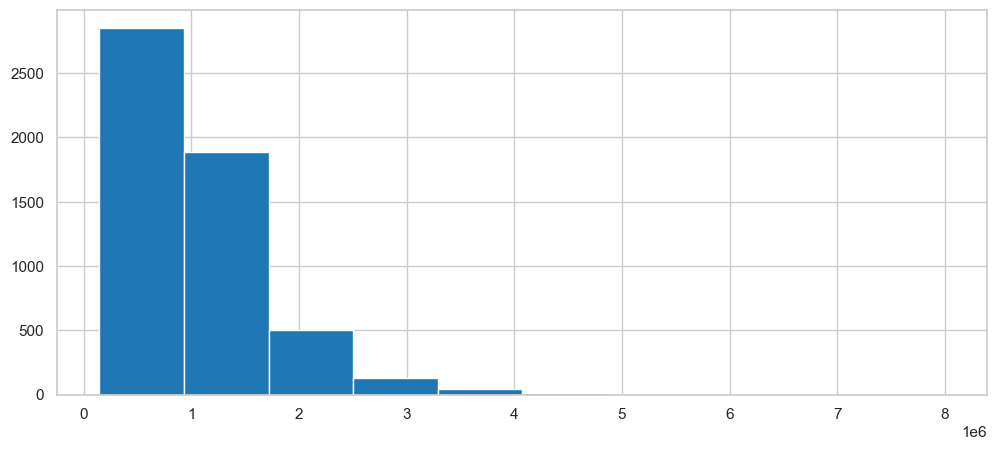

In [6]:
train_set.Price.hist()

<AxesSubplot:>

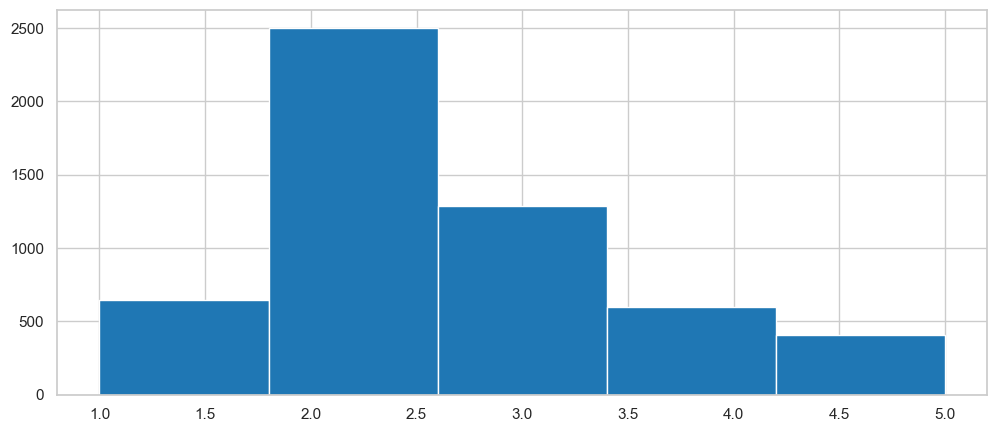

In [7]:
train_set['price_range'] = pd.cut(train_set.Price, bins=[.0, .5e6, 1e6, 1.5e6, 2e6, 10e6], labels=[1, 2, 3, 4, 5])
train_set['price_range'].hist(bins=5)

In [8]:
def train_val_split(train_set: pd.DataFrame, stratify_col: str = 'price_range'):
    train_set_target = train_set[stratify_col]

    X_train, X_valid, Y_train, Y_valid = train_test_split(
        train_set, 
        train_set_target, 
        stratify=train_set_target, 
        test_size=.15,
        random_state=0
    )
    
    return pd.concat([X_train, Y_train], axis=1), pd.concat([X_valid, Y_valid], axis=1)

In [9]:
train_set, valid_set = train_val_split(train_set)

## EDA

In [10]:
train_set.describe()

,Rooms,Price,Distance,Postcode,Bedroom2,Bathroom,Car,Landsize,BuildingArea,YearBuilt,Lattitude,Longtitude,Propertycount
count,4617.000000,4.617000e+03,4617.000000,4617.000000,4617.000000,4617.000000,4595.000000,4617.000000,2435.000000,2801.000000,4617.000000,4617.000000,4617.000000
mean,2.938705,1.078467e+06,10.261057,3105.903617,2.918562,1.537362,1.631338,538.927442,167.292700,1965.311674,-37.810119,144.994463,7379.346979
std,0.951790,6.454600e+05,6.038494,94.448991,0.993194,0.699995,0.990320,1614.688646,917.783312,36.274513,0.079175,0.108455,4341.521714
min,1.000000,1.450000e+05,0.000000,3000.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1830.000000,-38.174880,144.542370,389.000000
25%,2.000000,6.500000e+05,6.200000,3044.000000,2.000000,1.000000,1.000000,185.000000,92.000000,1940.000000,-37.857100,144.927500,4217.000000
50%,3.000000,9.000000e+05,9.200000,3084.000000,3.000000,1.000000,2.000000,451.000000,125.000000,1970.000000,-37.803500,144.999400,6543.000000
75%,3.000000,1.331000e+06,13.000000,3148.000000,3.000000,2.000000,2.000000,656.000000,175.000000,2000.000000,-37.757690,145.058790,10331.000000
max,8.000000,8.000000e+06,48.100000,3977.000000,20.000000,8.000000,10.000000,75100.000000,44515.000000,2018.000000,-37.408530,145.526350,21650.000000


<AxesSubplot:xlabel='Type', ylabel='count'>

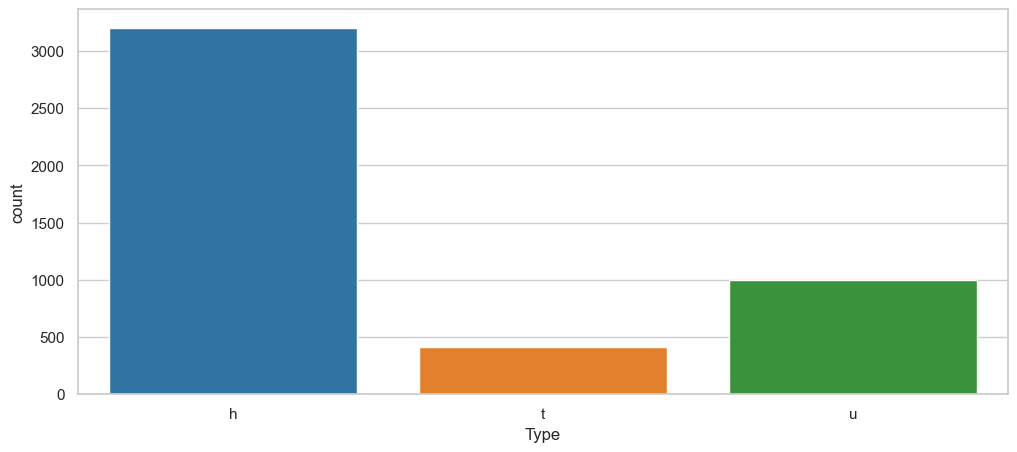

In [11]:
sns.countplot(x='Type', data=train_set)

<AxesSubplot:xlabel='Longtitude', ylabel='Lattitude'>

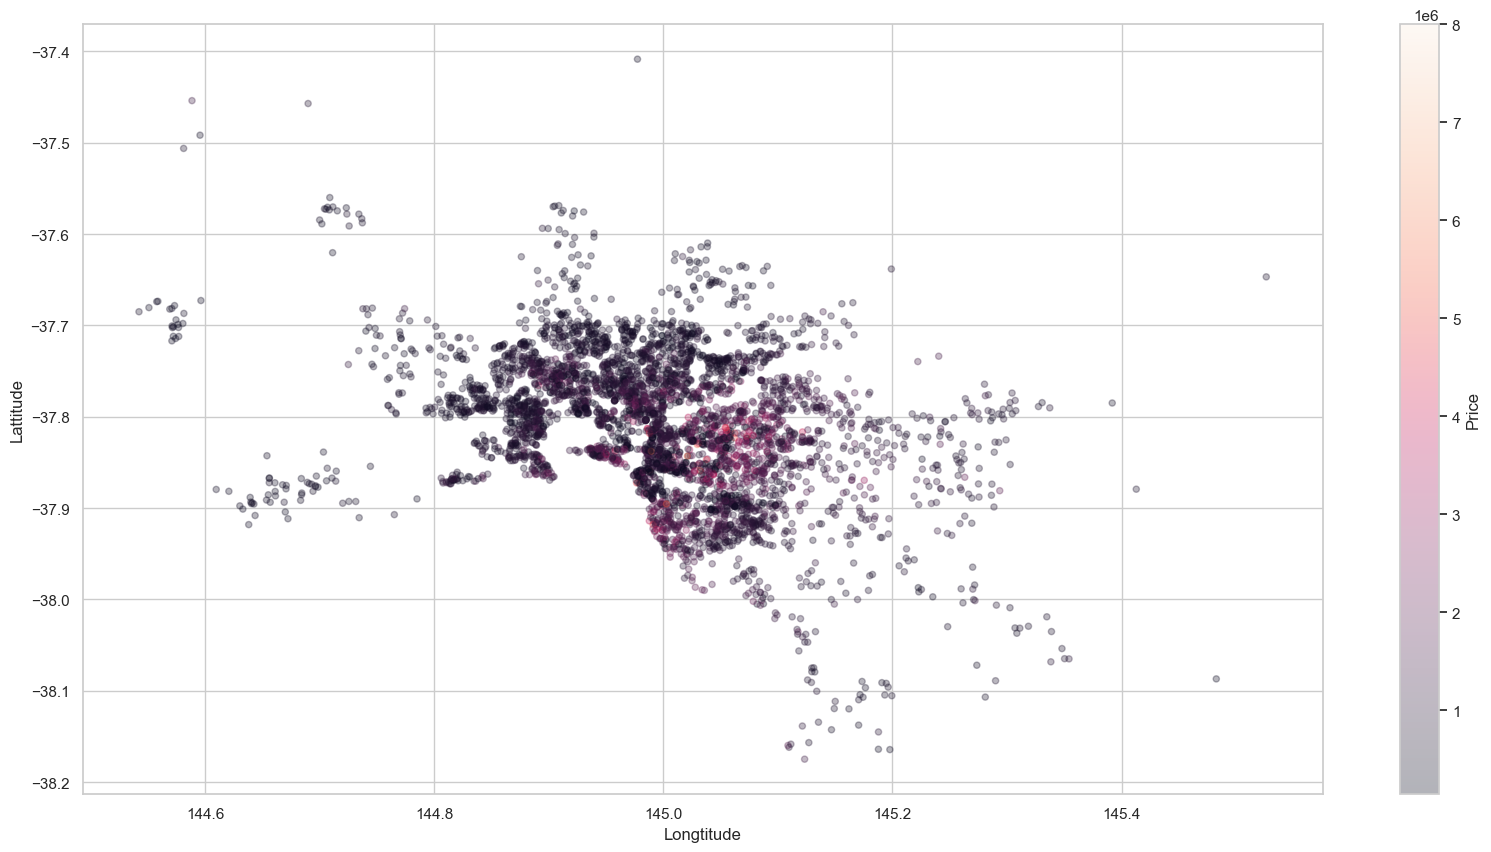

In [12]:
train_set.plot(
    kind='scatter',
    x='Longtitude',
    y='Lattitude',
    alpha=.3,
    figsize=(20, 10),
    c='Price', 
    cmap=plt.get_cmap('jet'),
    colorbar=True,
    sharex=False
)

<AxesSubplot:>

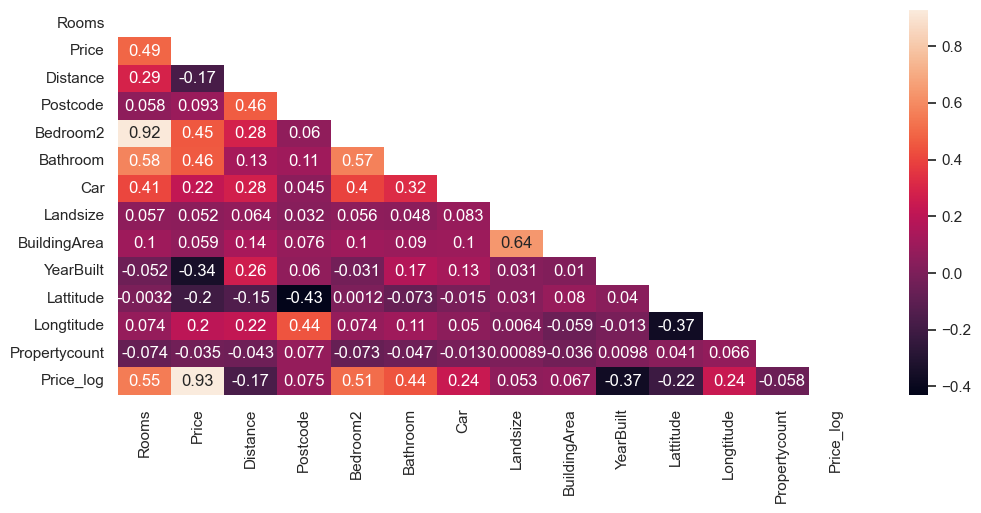

In [13]:
train_set.loc[:, 'Price_log'] = np.log(train_set['Price'])
corr = train_set.corr(numeric_only=True)

# Getting the Upper Triangle of the co-relation matrix
matrix = np.triu(corr)

sns.heatmap(
    corr,
    annot=True,
    mask=matrix
)

In [14]:
corr_sorted = corr['Price'].sort_values()
corr_sorted

YearBuilt       -0.344287
Lattitude       -0.204988
Distance        -0.174566
Propertycount   -0.035337
Landsize         0.051705
BuildingArea     0.059124
Postcode         0.092615
Longtitude       0.200117
Car              0.219901
Bedroom2         0.450831
Bathroom         0.457246
Rooms            0.488317
Price_log        0.927824
Price            1.000000
Name: Price, dtype: float64

In [15]:
corr_sorted = corr['Price_log'].sort_values()
corr_sorted

YearBuilt       -0.370563
Lattitude       -0.216350
Distance        -0.167657
Propertycount   -0.058089
Landsize         0.053004
BuildingArea     0.066616
Postcode         0.075252
Longtitude       0.239240
Car              0.242657
Bathroom         0.442409
Bedroom2         0.513359
Rooms            0.553088
Price            0.927824
Price_log        1.000000
Name: Price_log, dtype: float64

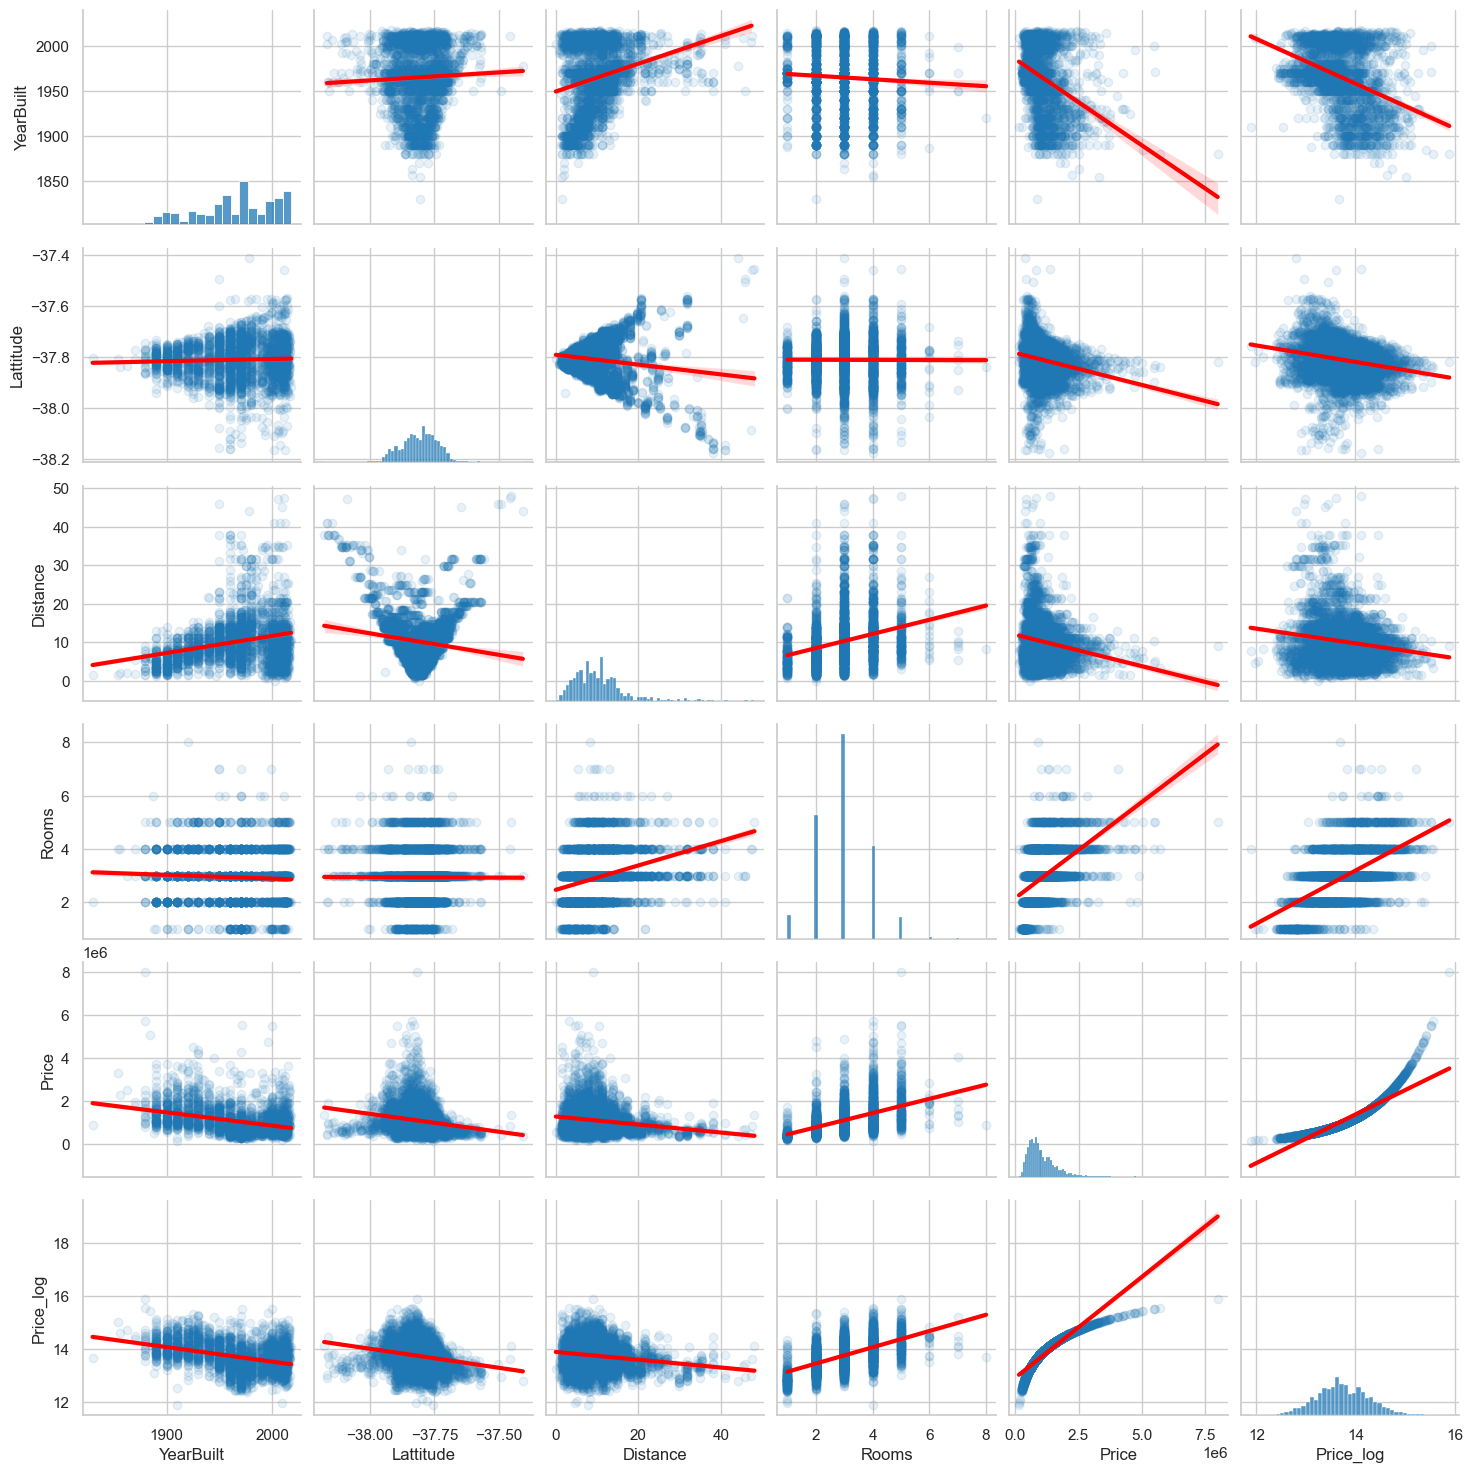

In [16]:
# Will do pair plot with most correlated values
sns.pairplot(
    train_set[corr_sorted.index[:3].tolist() + corr_sorted.index[-3:].tolist()],
    kind='reg',
    plot_kws={'line_kws':{'color':'red'}, 'scatter_kws': {'alpha': 0.1}}
)

## Data Processing

In [17]:
print(train_set.isnull().sum(axis=0).to_string())

Suburb              0
Address             0
Rooms               0
Type                0
Price               0
Method              0
SellerG             0
Date                0
Distance            0
Postcode            0
Bedroom2            0
Bathroom            0
Car                22
Landsize            0
BuildingArea     2182
YearBuilt        1816
CouncilArea       477
Lattitude           0
Longtitude          0
Regionname          0
Propertycount       0
price_range         0
price_range         0
Price_log           0


In [18]:
train_set_processed = train_set.copy()
valid_set_processed = valid_set.copy()
test_set_processed = test_set.copy()

### Handling NaNs

#### Car

<AxesSubplot:xlabel='Price', ylabel='Count'>

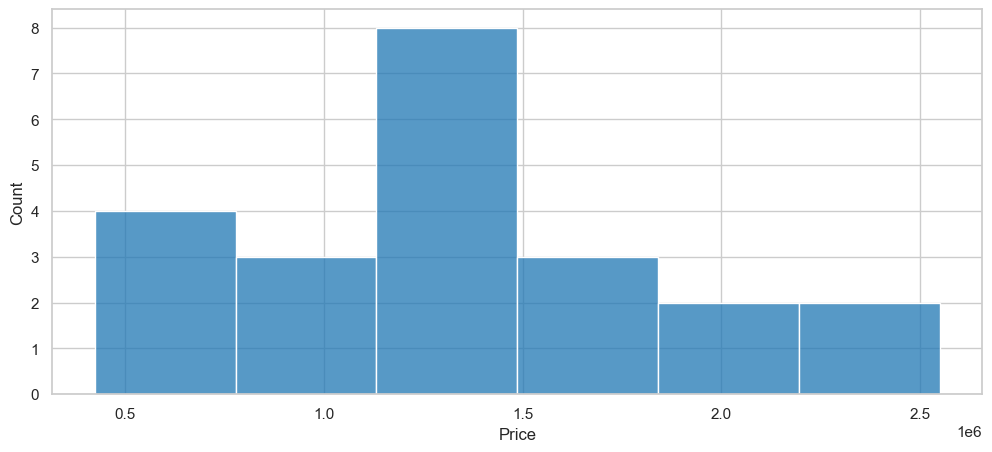

In [19]:
# How is the distribution of price when car is not set
sns.histplot(
    train_set_processed[train_set_processed.Car.isnull()]['Price']
)

In [20]:
def handle_null_car(train_df, valid_df, test_df, year_not_car: int = 1940):
    """
    We will assume that for the nulls in the year before year_not_car, are because there as effectively no car.
    
    """
    
    # For the other ones would place the median
    train_set_median = train_df['Car'].median()
    
    # For very aged houses
    train_df.loc[
        train_df['YearBuilt'] < year_not_car,
        'Car'
    ] = 0

    valid_df.loc[
        valid_df['YearBuilt'] < year_not_car,
        'Car'
    ] = 0

    test_df.loc[
        test_df['YearBuilt'] < year_not_car,
        'Car'
    ] = 0
    
    
    # And for the other houses
    train_df['Car'].fillna(train_set_median, inplace=True)
    valid_df['Car'].fillna(train_set_median, inplace=True)
    test_df['Car'].fillna(train_set_median, inplace=True)
    
    return train_df, valid_df, test_df

In [21]:
train_set_processed, valid_set_processed, test_set_processed = handle_null_car(train_set_processed, valid_set_processed, test_set_processed)

####  BuildingArea

In [22]:
def get_df_valid_size(df: pd.DataFrame, column: str):
    return df[
        (~df[column].isnull()) &
        (df[column] > 0)
    ]

In [23]:
def get_df_invalid_size(df: pd.DataFrame, column: str):
    return df[
        (df[column].isnull()) |
        (df[column] <= 0)
    ]

In [24]:
# We can see that half of the dataset is not useful
building_area_train_base = get_df_valid_size(train_set_processed, 'BuildingArea')
building_area_train_target = get_df_invalid_size(train_set_processed, 'BuildingArea')

print('Valid building area shape: ', building_area_train_base.shape)
print('Invalid building area shape: ', building_area_train_target.shape)

Valid building area shape:  (2429, 24)
Invalid building area shape:  (2188, 24)


We can try to find an easy relationship to the building area.

In [25]:
building_area_train_base.head(3)

,Suburb,Address,Rooms,Type,Price,Method,SellerG,Date,Distance,Postcode,Bedroom2,Bathroom,Car,Landsize,BuildingArea,YearBuilt,CouncilArea,Lattitude,Longtitude,Regionname,Propertycount,price_range,price_range,Price_log
index,,,,,,,,,,,,,,,,,,,,,,,,
1845,Kensington,51 Rankins Rd,2,h,765000.0,S,Nardella,10/12/2016,4.2,3031.0,2.0,1.0,2.0,158.0,76.0,1965.0,Melbourne,-37.7902,144.9319,Northern Metropolitan,5263.0,2,2,13.547631
1609,Hawthorn East,3 Jaques St,5,h,2500000.0,VB,RT,22/08/2016,7.5,3123.0,5.0,3.0,0.0,757.0,240.0,1925.0,Boroondara,-37.8176,145.0548,Southern Metropolitan,6482.0,5,5,14.731801
1329,Brighton,95 Cochrane St,4,h,3295888.0,S,Hodges,15/10/2016,11.2,3186.0,4.0,3.0,2.0,565.0,337.0,1990.0,Bayside,-37.8975,144.9991,Southern Metropolitan,10579.0,5,5,15.008186


In [26]:
from typing import List

def create_logs(df: pd.DataFrame, columns: List[str] = ['BuildingArea', 'Rooms', 'Bedroom2', 'Bathroom', 'Car', 'Landsize', 'YearBuilt']):
    for col in columns:
        df[col + '_log'] = np.log(df[col] + 1)
    
    df.replace([np.inf, -np.inf], 0, inplace=True)

    return df

In [27]:
# And we find that there are relationships of log-log of nearly 60&
building_area_train_base = create_logs(building_area_train_base)

building_area_train_base[
    ['BuildingArea', 'BuildingArea_log', 
    'Rooms', 'Bathroom', 'Bedroom2', 'Car',
    'Rooms_log', 'Bedroom2_log', 'Bathroom_log', 'Car_log']
].corr()\
    .sort_values('BuildingArea_log')

,BuildingArea,BuildingArea_log,Rooms,Bathroom,Bedroom2,Car,Rooms_log,Bedroom2_log,Bathroom_log,Car_log
Car_log,0.054543,0.123135,0.185633,0.189973,0.200415,0.952129,0.188723,0.203586,0.198270,1.000000
Car,0.082404,0.176139,0.249816,0.211311,0.260762,1.000000,0.250283,0.261262,0.217959,0.952129
BuildingArea,1.000000,0.298051,0.102986,0.090071,0.101215,0.082404,0.093942,0.092273,0.088312,0.054543
Bathroom,0.090071,0.472635,0.600139,1.000000,0.622556,0.211311,0.570584,0.579273,0.985693,0.189973
Bathroom_log,0.088312,0.487082,0.611385,0.985693,0.621076,0.217959,0.587054,0.588788,1.000000,0.198270
Bedroom2,0.101215,0.575477,0.944879,0.622556,1.000000,0.260762,0.932731,0.980448,0.621076,0.200415
Bedroom2_log,0.092273,0.581451,0.931077,0.579273,0.980448,0.261262,0.948541,1.000000,0.588788,0.203586
Rooms,0.102986,0.591785,1.000000,0.600139,0.944879,0.249816,0.983660,0.931077,0.611385,0.185633
Rooms_log,0.093942,0.597784,0.983660,0.570584,0.932731,0.250283,1.000000,0.948541,0.587054,0.188723
BuildingArea_log,0.298051,1.000000,0.591785,0.472635,0.575477,0.176139,0.597784,0.581451,0.487082,0.123135


So for this model, seems the variables that have great influence in the building area log are:
- Car
- Bathroom Logarithm
- Bedroom2 Logarithm
- Rooms Logarithm

In [28]:
building_area_features = ['Car', 'Bathroom_log', 'Bedroom2_log', 'Rooms_log']

In [29]:
Y_building_area_train_base = building_area_train_base.BuildingArea_log
X_building_area_train_base = building_area_train_base[building_area_features]

In [30]:
building_area_scaler = StandardScaler()
X_building_area_train_base = building_area_scaler.fit_transform(X_building_area_train_base)

In [31]:
# Huber Regressor is robust agains outliers
ba_linear_model = HuberRegressor().fit(X_building_area_train_base, Y_building_area_train_base)

In [32]:
# Can see in the train set which is r2 scoring
from sklearn.metrics import r2_score
round(r2_score(Y_building_area_train_base, ba_linear_model.predict(X_building_area_train_base)), 2)

0.38

And now we will use this model to imput the missing values in the building area.

In [33]:
from copy import deepcopy

def input_nan_logarithms(
    model, 
    scaler, 
    df: pd.DataFrame, 
    column_target: str, 
    column_features,
    log: bool = True,
    logging: bool = True,
):
    
    """
    Input the nans with a given model with the linear regression model for logarithms.
    Also, computes the MSE for the base dataframe (the one without nan).
    - model: the model trained
    - scaler: StandardScaler fitted
    - df: the dataframe for which we want to replace the nans
    - column_target: for which column do we want to replace the NaNs
    - column_features: list of features used from the df
    - log: if we are predicting a logarithm
    - logging: if we want to print out scores
    """
    df = deepcopy(df)
    column_target_model = column_target + '_log' if log else column_target
    
    # Get the valid and invalid dataframes
    base_df = get_df_valid_size(df, column_target)
    target_df = get_df_invalid_size(df, column_target)
    
    # Create the log features
    base_df = create_logs(base_df)
    target_df = create_logs(target_df)
    
    # Apply scaling
    Y_base_df = base_df[column_target_model]  # we expect the log of that variable
    X_base_df = base_df[column_features]
    X_base_df = scaler.transform(X_base_df)
    
    X_target_df = target_df[column_features]
    X_target_df = scaler.transform(X_target_df)
    Y_target_df_idx = target_df.index.values

    # And now we make the predictions
    prediction_base = model.predict(X_base_df)
    prediction_target = model.predict(X_target_df)
    
    # We compute scoring on the base
    comparison = [Y_base_df, prediction_base]
    comparison = [np.exp(x) if log else x for x in comparison]
    
    # Compute accuracy on the base
    if logging:
        print('-'*20)
        print('MSE error: ', mean_squared_error(
            *comparison,
            squared=False
        ))

        print('R2 error: ', r2_score(
            *comparison,
        ))
        print('-'*20)
    
    # And finally we fill with the exponential
    df.loc[
        Y_target_df_idx,
        column_target
    ] = np.exp(prediction_target)
    
    return df

In [34]:
train_set_processed = input_nan_logarithms(ba_linear_model, building_area_scaler, train_set_processed, 'BuildingArea', building_area_features, logging=False)
valid_set_processed = input_nan_logarithms(ba_linear_model, building_area_scaler, valid_set_processed, 'BuildingArea', building_area_features)
test_set_processed = input_nan_logarithms(ba_linear_model, building_area_scaler, test_set_processed, 'BuildingArea', building_area_features)

--------------------
MSE error:  69.52603252744271
R2 error:  0.3736920793256484
--------------------
--------------------
MSE error:  65.35100789196404
R2 error:  0.4321189081638367
--------------------


#### Landsize

This one does not have nulls, but have land size of 0. Which are values we can assumed that were put when they did not have a value for the land size.

Same analysis as before, but could include now the Building area & building area logs

In [35]:
# We can see that half of the dataset is not useful
landsize_train_base = get_df_valid_size(train_set_processed, 'Landsize')
landsize_train_target = get_df_invalid_size(train_set_processed, 'Landsize')

print('Valid landsize shape: ', landsize_train_base.shape)
print('Invalid landsize shape: ', landsize_train_target.shape)

Valid landsize shape:  (3996, 24)
Invalid landsize shape:  (621, 24)


In [36]:
landsize_train_base = create_logs(landsize_train_base)

landsize_train_base[
    ['Landsize', 'Landsize_log', 'BuildingArea', 'BuildingArea_log', 
    'Rooms', 'Bathroom', 'Bedroom2', 'Car',
    'Rooms_log', 'Bedroom2_log', 'Bathroom_log', 'Car_log']
].corr()\
    .sort_values('Landsize_log')

,Landsize,Landsize_log,BuildingArea,BuildingArea_log,Rooms,Bathroom,Bedroom2,Car,Rooms_log,Bedroom2_log,Bathroom_log,Car_log
Bathroom_log,0.025984,0.120748,0.090788,0.561102,0.574853,0.985606,0.551366,0.211800,0.552880,0.543217,1.000000,0.204452
BuildingArea,0.397040,0.124420,1.000000,0.298764,0.104459,0.093366,0.097991,0.067220,0.096865,0.092914,0.090788,0.047003
Bathroom,0.028074,0.128715,0.093366,0.550199,0.574058,1.000000,0.558348,0.205617,0.547071,0.540033,0.985606,0.194081
BuildingArea_log,0.070046,0.221018,0.298764,1.000000,0.653532,0.550199,0.609013,0.203775,0.657738,0.626760,0.561102,0.173272
Car_log,0.059392,0.242184,0.047003,0.173272,0.206480,0.194081,0.210083,0.950907,0.215144,0.222460,0.204452,1.000000
Bedroom2_log,-0.003718,0.245748,0.092914,0.626760,0.903210,0.540033,0.964489,0.252774,0.917855,1.000000,0.543217,0.222460
Car,0.061744,0.252944,0.067220,0.203775,0.245354,0.205617,0.242454,1.000000,0.251051,0.252774,0.211800,0.950907
Rooms_log,-0.006388,0.256403,0.096865,0.657738,0.985214,0.547071,0.887081,0.251051,1.000000,0.917855,0.552880,0.215144
Bedroom2,0.006477,0.261295,0.097991,0.609013,0.898000,0.558348,1.000000,0.242454,0.887081,0.964489,0.551366,0.210083
Rooms,0.003948,0.273136,0.104459,0.653532,1.000000,0.574058,0.898000,0.245354,0.985214,0.903210,0.574853,0.206480


Have tried training for both Landsize & Landsize log, and I get better R2 scoring for the Landsize.

In [37]:
landsize_features = ['Bathroom', 'BuildingArea', 'Car', 'Rooms', 'Bedroom2']

In [38]:
Y_landsize_train_base = landsize_train_base.Landsize
X_landsize_train_base = landsize_train_base[landsize_features]

In [39]:
landsize_scaler = StandardScaler()
X_landsize_train_base = landsize_scaler.fit_transform(X_landsize_train_base)

In [40]:
ls_linear_model = HuberRegressor().fit(X_landsize_train_base, Y_landsize_train_base)

In [41]:
round(r2_score(Y_landsize_train_base, ls_linear_model.predict(X_landsize_train_base)), 2)

0.15

Will try to fill the NaNs with the model.

In [42]:
_ = input_nan_logarithms(ls_linear_model, landsize_scaler, train_set_processed, 'Landsize', landsize_features, log=False, logging=False)
_ = input_nan_logarithms(ls_linear_model, landsize_scaler, valid_set_processed, 'Landsize', landsize_features, log=False)
_ = input_nan_logarithms(ls_linear_model, landsize_scaler, test_set_processed, 'Landsize', landsize_features, log=False)

--------------------
MSE error:  1209.6312618242114
R2 error:  -0.023287764011138856
--------------------
--------------------
MSE error:  5404.301454853171
R2 error:  -0.001995399235138251
--------------------


In [43]:
# We can see a huge MSE, so we will go for another way to fill the nans
pd.DataFrame(train_set_processed\
    .groupby(['Regionname', 'Type'])\
    .median(numeric_only=True)['Landsize'])\
    .T

Regionname Eastern Metropolitan               Eastern Victoria         \
Type                          h      t      u                h      u   
Landsize                  696.5  229.0  211.0            741.5  213.0   

Regionname Northern Metropolitan             Northern Victoria  \
Type                           h      t    u                 h   
Landsize                   454.0  123.5  0.0             753.5   

Regionname South-Eastern Metropolitan               Southern Metropolitan  \
Type                                h      t      u                     h   
Landsize                        606.0  269.0  199.0                 588.0   

Regionname             Western Metropolitan               Western Victoria  
Type            t    u                    h      t      u                h  
Landsize    266.0  0.0                534.0  201.0  126.5            590.0

In [44]:
# First, we will handle this grouping
train_set_processed['Regionname'].value_counts()

Southern Metropolitan         1575
Northern Metropolitan         1286
Western Metropolitan          1034
Eastern Metropolitan           504
South-Eastern Metropolitan     169
Eastern Victoria                20
Western Victoria                15
Northern Victoria               14
Name: Regionname, dtype: int64

In [45]:
other_region_name_cols = ['Eastern Victoria', 'Western Victoria', 'Northern Victoria']

train_set_processed.loc[
    train_set_processed['Regionname'].isin(other_region_name_cols),
    'Regionname'
] = 'Other'

valid_set_processed.loc[
    valid_set_processed['Regionname'].isin(other_region_name_cols),
    'Regionname'
] = 'Other'

test_set_processed.loc[
    test_set_processed['Regionname'].isin(other_region_name_cols),
    'Regionname'
] = 'Other'

In [46]:
# And we can check again
train_set_processed['Regionname'].value_counts()

Southern Metropolitan         1575
Northern Metropolitan         1286
Western Metropolitan          1034
Eastern Metropolitan           504
South-Eastern Metropolitan     169
Other                           49
Name: Regionname, dtype: int64

In [47]:
landsize_by_region_type = pd.DataFrame(train_set_processed\
    .groupby(['Regionname', 'Type'])\
    .median(numeric_only=True)['Landsize'])  # median to do not be influenced by outliers of the 0

landsize_by_region_type.T

Regionname Eastern Metropolitan               Northern Metropolitan         \
Type                          h      t      u                     h      t   
Landsize                  696.5  229.0  211.0                 454.0  123.5   

Regionname       Other        South-Eastern Metropolitan                \
Type          u      h      u                          h      t      u   
Landsize    0.0  675.0  213.0                      606.0  269.0  199.0   

Regionname Southern Metropolitan             Western Metropolitan         \
Type                           h      t    u                    h      t   
Landsize                   588.0  266.0  0.0                534.0  201.0   

Regionname         
Type            u  
Landsize    126.5

In [48]:
# And this one will be used in the case we get a 0
landsize_by_region = pd.DataFrame(train_set_processed\
    .groupby(['Regionname'])\
    .median(numeric_only=True)['Landsize'])

landsize_by_region.T

Regionname,Eastern Metropolitan,Northern Metropolitan,Other,South-Eastern Metropolitan,Southern Metropolitan,Western Metropolitan
Landsize,649.5,326.5,675.0,590.0,375.0,463.0


Will use this as a hash map, of values that will be replaced for the NaN of the dataframes.

In [49]:
def handle_null_landsize(df: pd.DataFrame):
    for idx, row in df.iterrows():
        landsize = row['Landsize']
        
        if pd.isnull(landsize) or landsize == 0:
            region_name = row['Regionname']
            type_name = row['Type']
            
            new_value = landsize_by_region_type.loc[region_name, type_name].values[0]
            new_value = new_value if new_value > 0.0 else landsize_by_region.loc[region_name].values[0]
            
            df.loc[
                idx, 'Landsize'
            ] = new_value
    
    return df

In [50]:
train_set_processed = handle_null_landsize(train_set_processed)
valid_set_processed = handle_null_landsize(valid_set_processed)
test_set_processed = handle_null_landsize(test_set_processed)

#### CouncilArea

Will can try to use a **k-nearest neighbor**, as the council area depends a lot in the position of longtitude and lattitude.

In [51]:
train_set_processed.head(3)

,Suburb,Address,Rooms,Type,Price,Method,SellerG,Date,Distance,Postcode,Bedroom2,Bathroom,Car,Landsize,BuildingArea,YearBuilt,CouncilArea,Lattitude,Longtitude,Regionname,Propertycount,price_range,price_range,Price_log
index,,,,,,,,,,,,,,,,,,,,,,,,
1845,Kensington,51 Rankins Rd,2,h,765000.0,S,Nardella,10/12/2016,4.2,3031.0,2.0,1.0,2.0,158.0,76.000000,1965.0,Melbourne,-37.79020,144.93190,Northern Metropolitan,5263.0,2,2,13.547631
828,Blackburn,18 Masons Rd,2,h,1500000.0,S,Noel,15/07/2017,13.4,3130.0,2.0,1.0,1.0,1021.0,83.389149,NaN,Whitehorse,-37.83189,145.15785,Eastern Metropolitan,5713.0,3,3,14.220976
973,Preston,1/61 Eton St,3,h,485000.0,PI,Barry,12/11/2016,8.8,3072.0,3.0,1.0,1.0,244.0,117.473722,NaN,Darebin,-37.74440,145.02020,Northern Metropolitan,14577.0,1,1,13.091904


In [52]:
test_set_processed.isnull().sum(axis=0)

Suburb              0
Address             0
Rooms               0
Type                0
Method              0
SellerG             0
Date                0
Distance            0
Postcode            0
Bedroom2            0
Bathroom            0
Car                 0
Landsize            0
BuildingArea        0
YearBuilt        3245
CouncilArea       816
Lattitude           0
Longtitude          0
Regionname          0
Propertycount       0
dtype: int64

In [53]:
train_set_base = train_set_processed.dropna(subset=['CouncilArea'])
train_set_target = train_set_processed[train_set_processed['CouncilArea'].isna()]

# Explicative variables
X_train_base_set_council = train_set_base[['Lattitude', 'Longtitude']]
X_train_target_set_council = train_set_target[['Lattitude', 'Longtitude']]
X_train_target_set_council_index = X_train_target_set_council.index

# Target variables
Y_train_base_set_council = train_set_base['CouncilArea'].values.ravel()

In [54]:
# Scale the inputs
scaler = StandardScaler()

X_train_base_set_council = scaler.fit_transform(X_train_base_set_council)
X_train_target_set_council = scaler.transform(X_train_target_set_council)

In [55]:
# Train the model
n_council_area = train_set_processed['CouncilArea'].nunique()
knn_council_area = KNeighborsClassifier(n_council_area)

knn_council_area.fit(X_train_base_set_council, Y_train_base_set_council)

KNeighborsClassifier(n_neighbors=32)

In [56]:
valid_set_base = valid_set_processed.dropna(subset='CouncilArea')
X_valid_base_set_council = valid_set_base[['Lattitude', 'Longtitude']]
Y_valid_base_set_council = valid_set_base['CouncilArea'].values.ravel()

accuracy_score(knn_council_area.predict(X_valid_base_set_council), Y_valid_base_set_council)

0.0027063599458728013

We can see that this is not giving us very good results.

In [57]:
train_set_processed['CouncilArea'].value_counts()

Boroondara        420
Moreland          379
Moonee Valley     328
Darebin           317
Glen Eira         286
                 ... 
Nillumbik          13
Yarra Ranges        6
Macedon Ranges      2
Unavailable         1
Cardinia            1
Name: CouncilArea, Length: 32, dtype: int64

In [58]:
train_set_processed['CouncilArea'].fillna('Unknown', inplace=True)
valid_set_processed['CouncilArea'].fillna('Unknown', inplace=True)
test_set_processed['CouncilArea'].fillna('Unknown', inplace=True)

### YearBuilt

In [59]:
# We can see that half of the dataset is not useful
yearbuilt_train_base = get_df_valid_size(train_set_processed, 'YearBuilt')
yearbuilt_train_target = get_df_invalid_size(train_set_processed, 'YearBuilt')

print('Valid year built shape: ', yearbuilt_train_base.shape)
print('Invalid year built shape: ', yearbuilt_train_target.shape)

Valid year built shape:  (2801, 24)
Invalid year built shape:  (1816, 24)


In [60]:
yearbuilt_train_base = create_logs(yearbuilt_train_base)

yearbuilt_train_base[
    ['YearBuilt', 'YearBuilt_log', 'Landsize', 'Landsize_log', 'BuildingArea', 'BuildingArea_log', 
    'Rooms', 'Bathroom', 'Bedroom2', 'Car',
    'Rooms_log', 'Bedroom2_log', 'Bathroom_log', 'Car_log']
].corr()\
    .sort_values('YearBuilt_log')

,YearBuilt,YearBuilt_log,Landsize,Landsize_log,BuildingArea,BuildingArea_log,Rooms,Bathroom,Bedroom2,Car,Rooms_log,Bedroom2_log,Bathroom_log,Car_log
Rooms_log,-0.056214,-0.056585,-0.004781,0.264055,0.560872,0.723519,0.983650,0.574446,0.936184,0.236880,1.000000,0.951975,0.587920,0.169639
Rooms,-0.052247,-0.052534,0.003046,0.288586,0.584902,0.720436,1.000000,0.606033,0.948620,0.235211,0.983650,0.934433,0.614393,0.165618
Bedroom2_log,-0.034455,-0.034822,-0.003436,0.256538,0.544406,0.703298,0.934433,0.579614,0.980780,0.246213,0.951975,1.000000,0.586285,0.183671
Bedroom2,-0.031225,-0.031507,0.004685,0.283179,0.567339,0.700777,0.948620,0.624594,1.000000,0.244425,0.936184,0.980780,0.620874,0.179543
Landsize_log,-0.022088,-0.019467,0.555920,1.000000,0.222468,0.238338,0.288586,0.176992,0.283179,0.227653,0.264055,0.256538,0.172450,0.195090
BuildingArea_log,-0.016580,-0.017569,0.012920,0.238338,0.769344,1.000000,0.720436,0.574688,0.700777,0.209780,0.723519,0.703298,0.586641,0.148509
BuildingArea,0.002039,0.001105,0.020725,0.222468,1.000000,0.769344,0.584902,0.498012,0.567339,0.150295,0.560872,0.544406,0.499321,0.101729
Landsize,0.044958,0.045044,1.000000,0.555920,0.020725,0.012920,0.003046,0.054429,0.004685,0.064246,-0.004781,-0.003436,0.055845,0.063227
Bathroom,0.172785,0.170563,0.054429,0.176992,0.498012,0.574688,0.606033,1.000000,0.624594,0.217656,0.574446,0.579614,0.986411,0.189202
Bathroom_log,0.186393,0.184063,0.055845,0.172450,0.499321,0.586641,0.614393,0.986411,0.620874,0.225627,0.587920,0.586285,1.000000,0.198723


So we could try out a model with:
- Car Logarithm
- Car
- Bathroom Logarithm
- Bathroom

In [61]:
yearbuilt_features = ['Car_log', 'Car', 'Bathroom_log', 'Bathroom']
Y_yearbuilt_train_base = yearbuilt_train_base.YearBuilt_log
X_yearbuilt_train_base = yearbuilt_train_base[yearbuilt_features]

In [62]:
yearbuilt_scaler = StandardScaler()
X_yearbuilt_train_base = yearbuilt_scaler.fit_transform(X_yearbuilt_train_base)
yb_linear_model = HuberRegressor().fit(X_yearbuilt_train_base, Y_yearbuilt_train_base)

In [63]:
# And we can see a model that has good 
round(r2_score(Y_yearbuilt_train_base, yb_linear_model.predict(X_yearbuilt_train_base)), 2)

0.57

In [64]:
train_set_processed = input_nan_logarithms(yb_linear_model, yearbuilt_scaler, train_set_processed, 'YearBuilt', yearbuilt_features, logging=False)
valid_set_processed = input_nan_logarithms(yb_linear_model, yearbuilt_scaler, valid_set_processed, 'YearBuilt', yearbuilt_features)
test_set_processed = input_nan_logarithms(yb_linear_model, yearbuilt_scaler, test_set_processed, 'YearBuilt', yearbuilt_features)

--------------------
MSE error:  24.482902421279082
R2 error:  0.5393168281067002
--------------------
--------------------
MSE error:  26.198356178945414
R2 error:  0.5233523625812985
--------------------


With this, we have handled all the Nulls that we had for this df.

In [65]:
print(train_set_processed.isnull().sum(axis=0).to_string())

Suburb           0
Address          0
Rooms            0
Type             0
Price            0
Method           0
SellerG          0
Date             0
Distance         0
Postcode         0
Bedroom2         0
Bathroom         0
Car              0
Landsize         0
BuildingArea     0
YearBuilt        0
CouncilArea      0
Lattitude        0
Longtitude       0
Regionname       0
Propertycount    0
price_range      0
price_range      0
Price_log        0


## Handling Categorical Data

There are some categorical variables that have too much different values.

So instead of using all of them, we are going to group them depending if they tend to have high/medium/low price values.

In [74]:
def plot_distribution_grouped_field(
    df,
    field: str, 
    expensive_divisor: int = 1.5e6, 
    premium_divisor: int = 2e6,
    font_size: int = 6
):
    
    grouped_pricing = df\
        .groupby(field)\
        .mean()['Price']\
        .sort_values()
    
    grouped_names = grouped_pricing.index.values.tolist()

    fig, ax = plt.subplots(figsize=(20, 10))

    sns.scatterplot(
        x=grouped_names,
        y=grouped_pricing,
        ax=ax
    )

    plt.axhline(
        y=expensive_divisor, 
        color='green',
        linestyle='--',
        label='Expensive divisor'
    )

    plt.axhline(
        y=premium_divisor, 
        color='orange',
        linestyle='dotted',
        label='Premium divisor'
    )

    plt.xticks(
        size=font_size,
        rotation=90
    );

    plt.legend()
    
    return grouped_pricing, grouped_names

In [79]:
def classify_category(
    group_pricing, 
    df: pd.DataFrame,
    input_column_name: str,
    output_column_name: str,
    premium_threshold = 2e6,
    expensive_threshold = 1.5e6,
    
):
    
    # We get the group names
    premium_group = list(
        group_pricing[group_pricing >= premium_threshold].index.values
    )
    
    expensive_group = list(
        group_pricing[
            (group_pricing >= expensive_threshold) & 
            (group_pricing < premium_threshold)
        ].index.values
    )
    
    normal_group = list(
        group_pricing[group_pricing < expensive_threshold].index.values
    )
    
    # And now we make the classification
    df.loc[
        df[input_column_name].isin(premium_group), 
        output_column_name
    ] = 2

    df.loc[
        df[input_column_name].isin(expensive_group), 
        output_column_name
    ] = 1

    df.loc[
        df[input_column_name].isin(normal_group), 
        output_column_name
    ] = 0
    
    # And in the case some of it has not been classified: -1 as we consider them less than normal
    df[output_column_name].fillna(-1, inplace=True)
    
    return df

### SellerG

In [66]:
train_set_processed.head(3)

,Suburb,Address,Rooms,Type,Price,Method,SellerG,Date,Distance,Postcode,Bedroom2,Bathroom,Car,Landsize,BuildingArea,YearBuilt,CouncilArea,Lattitude,Longtitude,Regionname,Propertycount,price_range,price_range,Price_log
index,,,,,,,,,,,,,,,,,,,,,,,,
1845,Kensington,51 Rankins Rd,2,h,765000.0,S,Nardella,10/12/2016,4.2,3031.0,2.0,1.0,2.0,158.0,76.000000,1965.000000,Melbourne,-37.79020,144.93190,Northern Metropolitan,5263.0,2,2,13.547631
828,Blackburn,18 Masons Rd,2,h,1500000.0,S,Noel,15/07/2017,13.4,3130.0,2.0,1.0,1.0,1021.0,83.389149,1971.243876,Whitehorse,-37.83189,145.15785,Eastern Metropolitan,5713.0,3,3,14.220976
973,Preston,1/61 Eton St,3,h,485000.0,PI,Barry,12/11/2016,8.8,3072.0,3.0,1.0,1.0,244.0,117.473722,1971.243876,Darebin,-37.74440,145.02020,Northern Metropolitan,14577.0,1,1,13.091904


/var/folders/p0/12vcby4x6nxfqn51s513m16c0000gn/T/ipykernel_76187/2600807695.py:9: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  grouped_pricing = df\


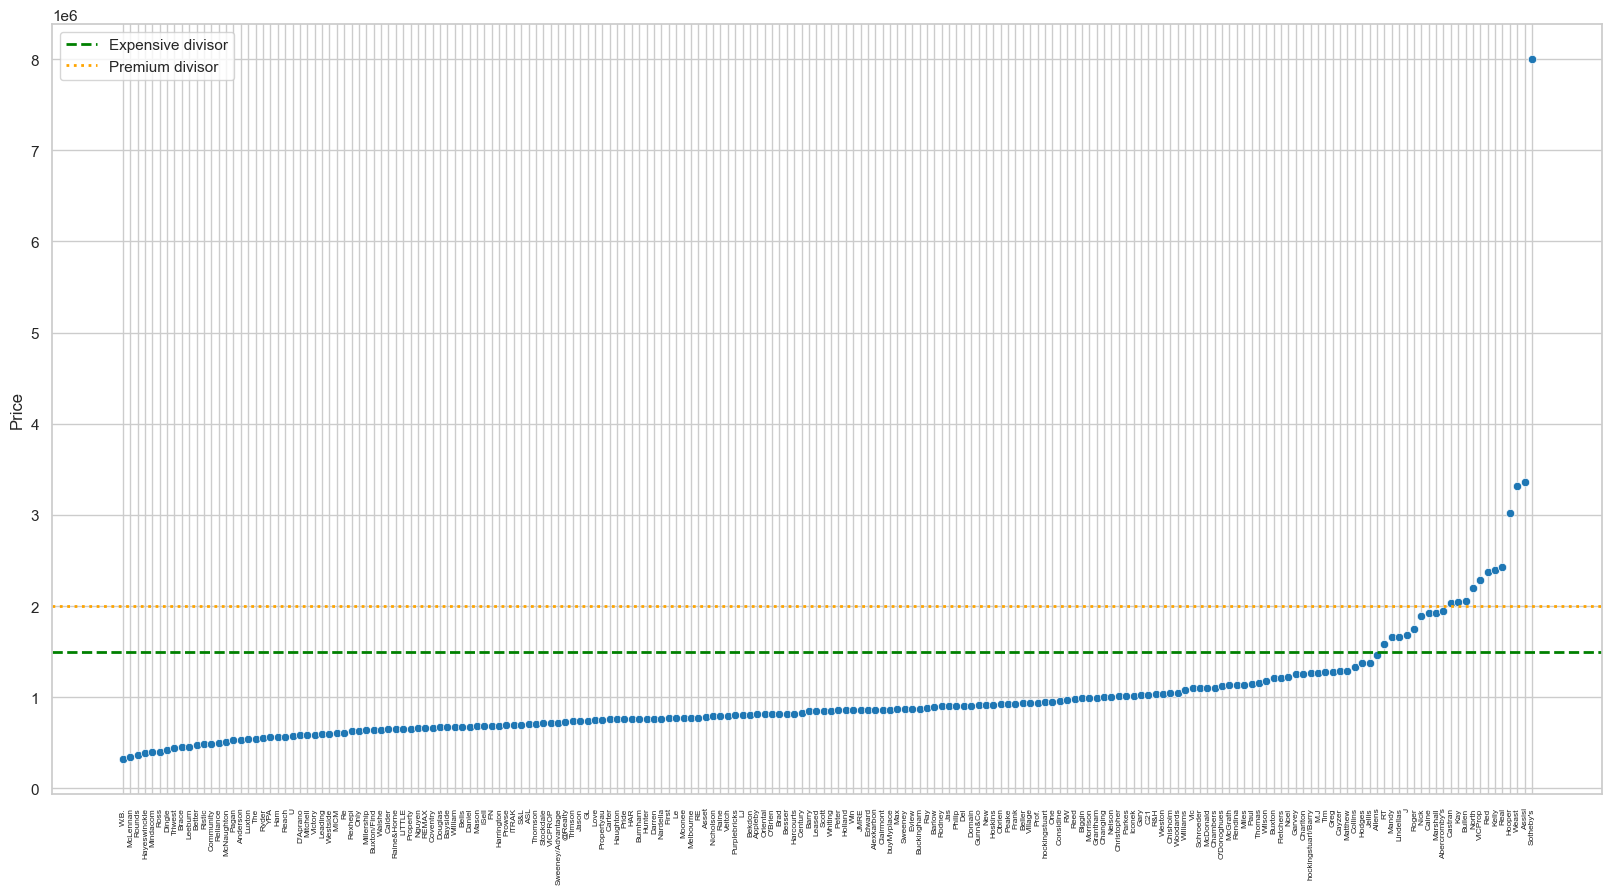

In [76]:
seller_pricing, _ = plot_distribution_grouped_field(train_set_processed, field='SellerG')

In [80]:
train_set_processed = classify_category(
    df=train_set_processed,
    group_pricing=seller_pricing,
    input_column_name='SellerG',
    output_column_name='seller_class',
    premium_threshold=2e6,
    expensive_threshold=1.5e6,
)

valid_set_processed = classify_category(
    df=valid_set_processed,
    group_pricing=seller_pricing,
    input_column_name='SellerG',
    output_column_name='seller_class',
    premium_threshold=2e6,
    expensive_threshold=1.5e6,
)

test_set_processed = classify_category(
    df=test_set_processed,
    group_pricing=seller_pricing,
    input_column_name='SellerG',
    output_column_name='seller_class',
    premium_threshold=2e6,
    expensive_threshold=1.5e6,
)

### Suburb

/var/folders/p0/12vcby4x6nxfqn51s513m16c0000gn/T/ipykernel_76187/2600807695.py:9: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  grouped_pricing = df\


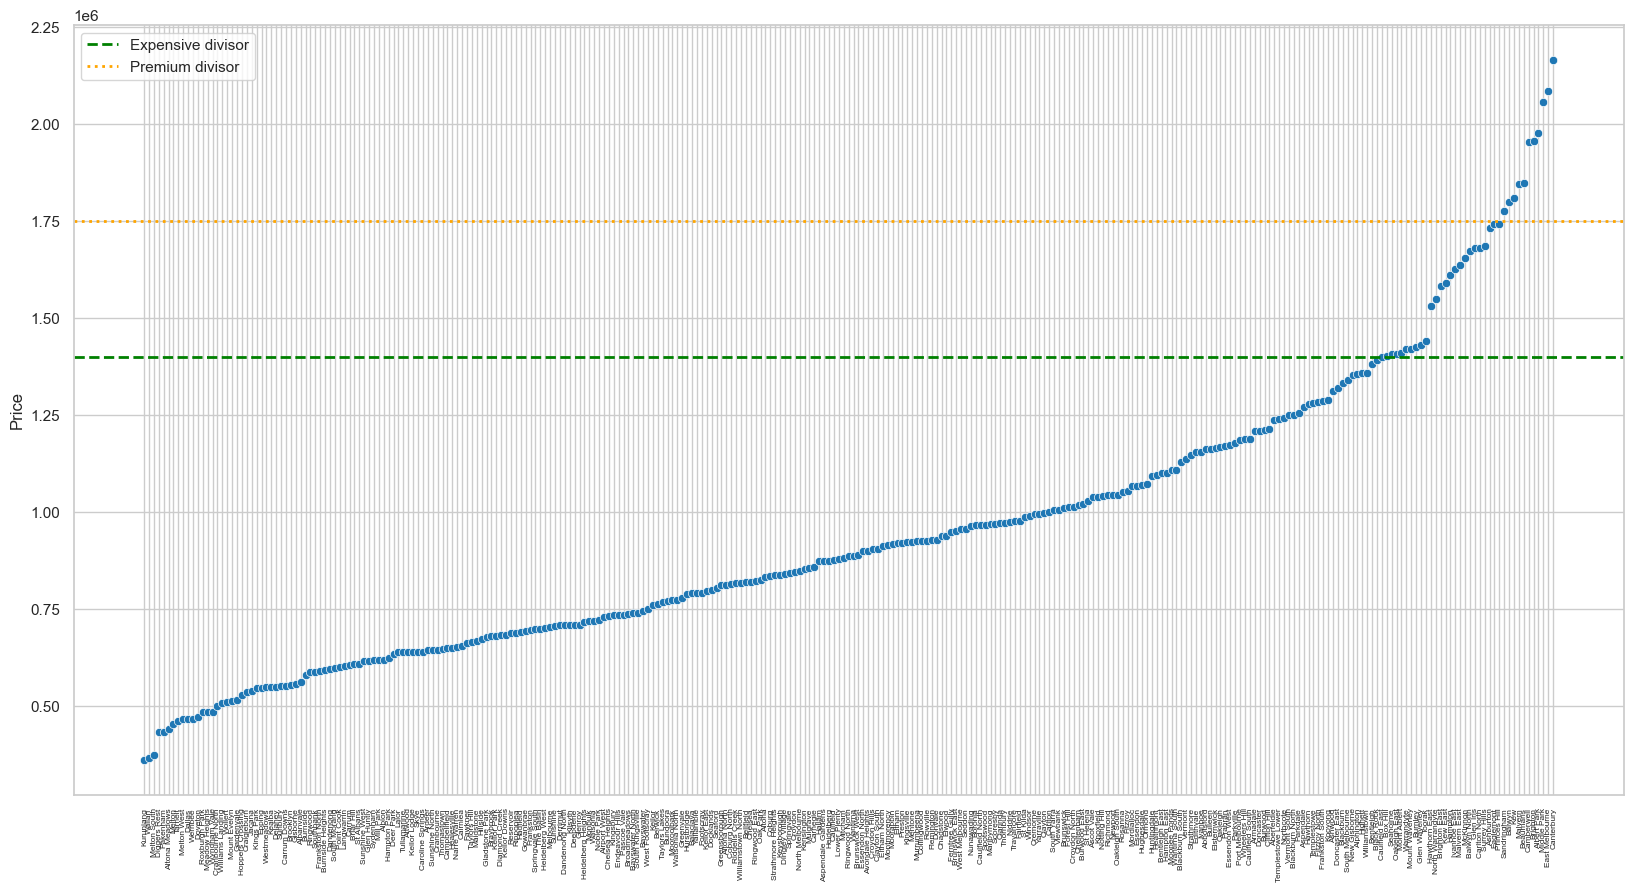

In [75]:
suburb_pricing, _ = plot_distribution_grouped_field(
    train_set_processed,
    field='Suburb', 
    expensive_divisor=1.4e6, 
    premium_divisor=1.75e6
)